Group 4 Members

* Shyam Akhil Nekkanti - 8982123
* Jun He (Helena) - 8903073
* Zheming Li (Brendan) - 8914152

### Dataset Description

ONLY USING US DATA

/var/folders/l7/z_g7053948z2cyzhzs9wvfg40000gn/T/ipykernel_79140/3088168927.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Loaded 40949 records

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                40949 non-null  object             
 1   trending_date           40949 non-null  datetime64[ns]     
 2   title                   40949 non-null  object             
 3   channel_title           40949 non-null  object             
 4   category_id             40949 non-null  int64              
 5   publish_time            40949 non-null  datetime64[ns, UTC]
 6   tags                    40949 non-null  object             
 7   views                   40949 non-null  int64              
 8   likes                   40949 non-null  int64              
 9   dislikes                40949 non-null  int64              
 10  comment_count           40949 non-null  int64              
 11  t

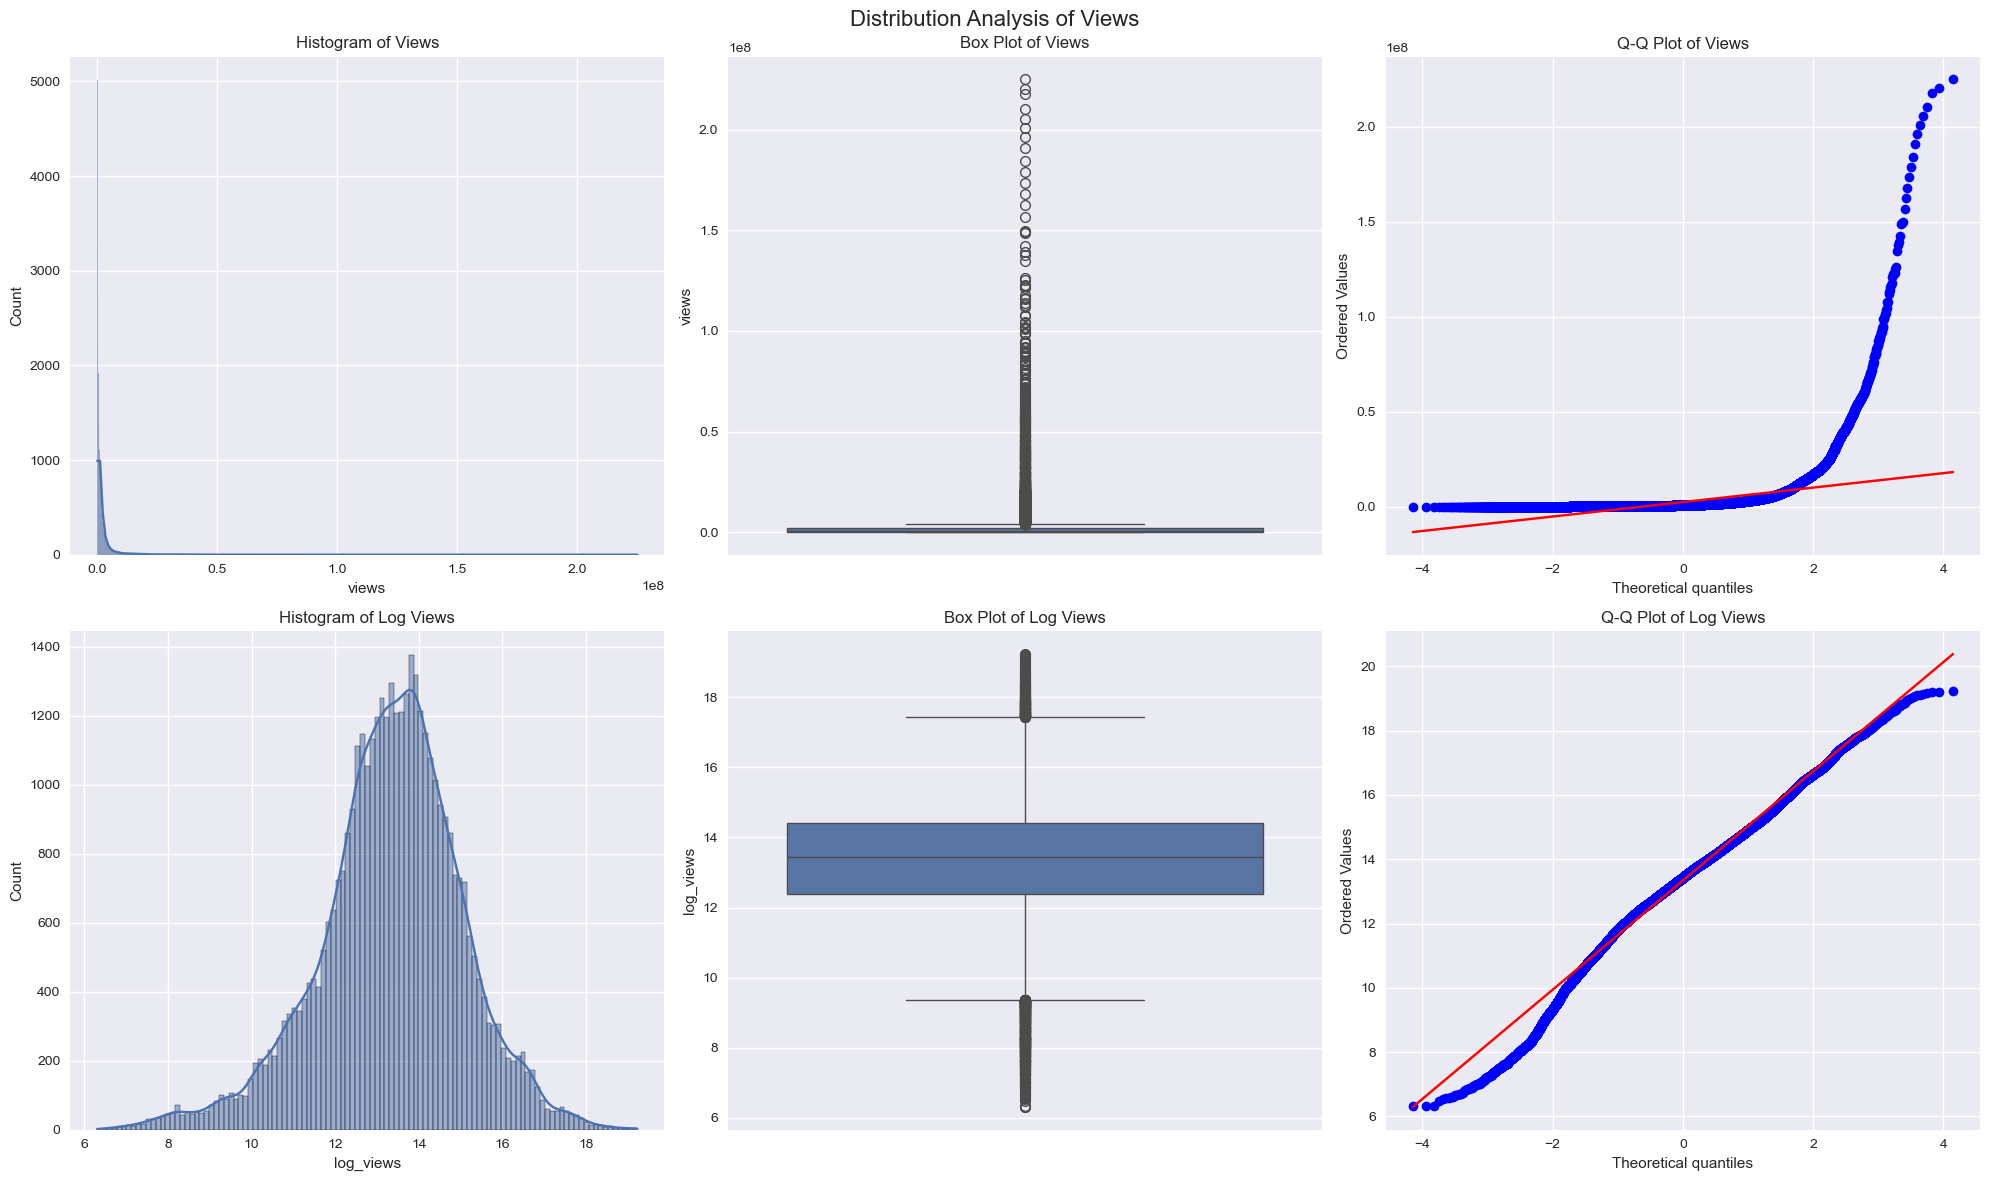

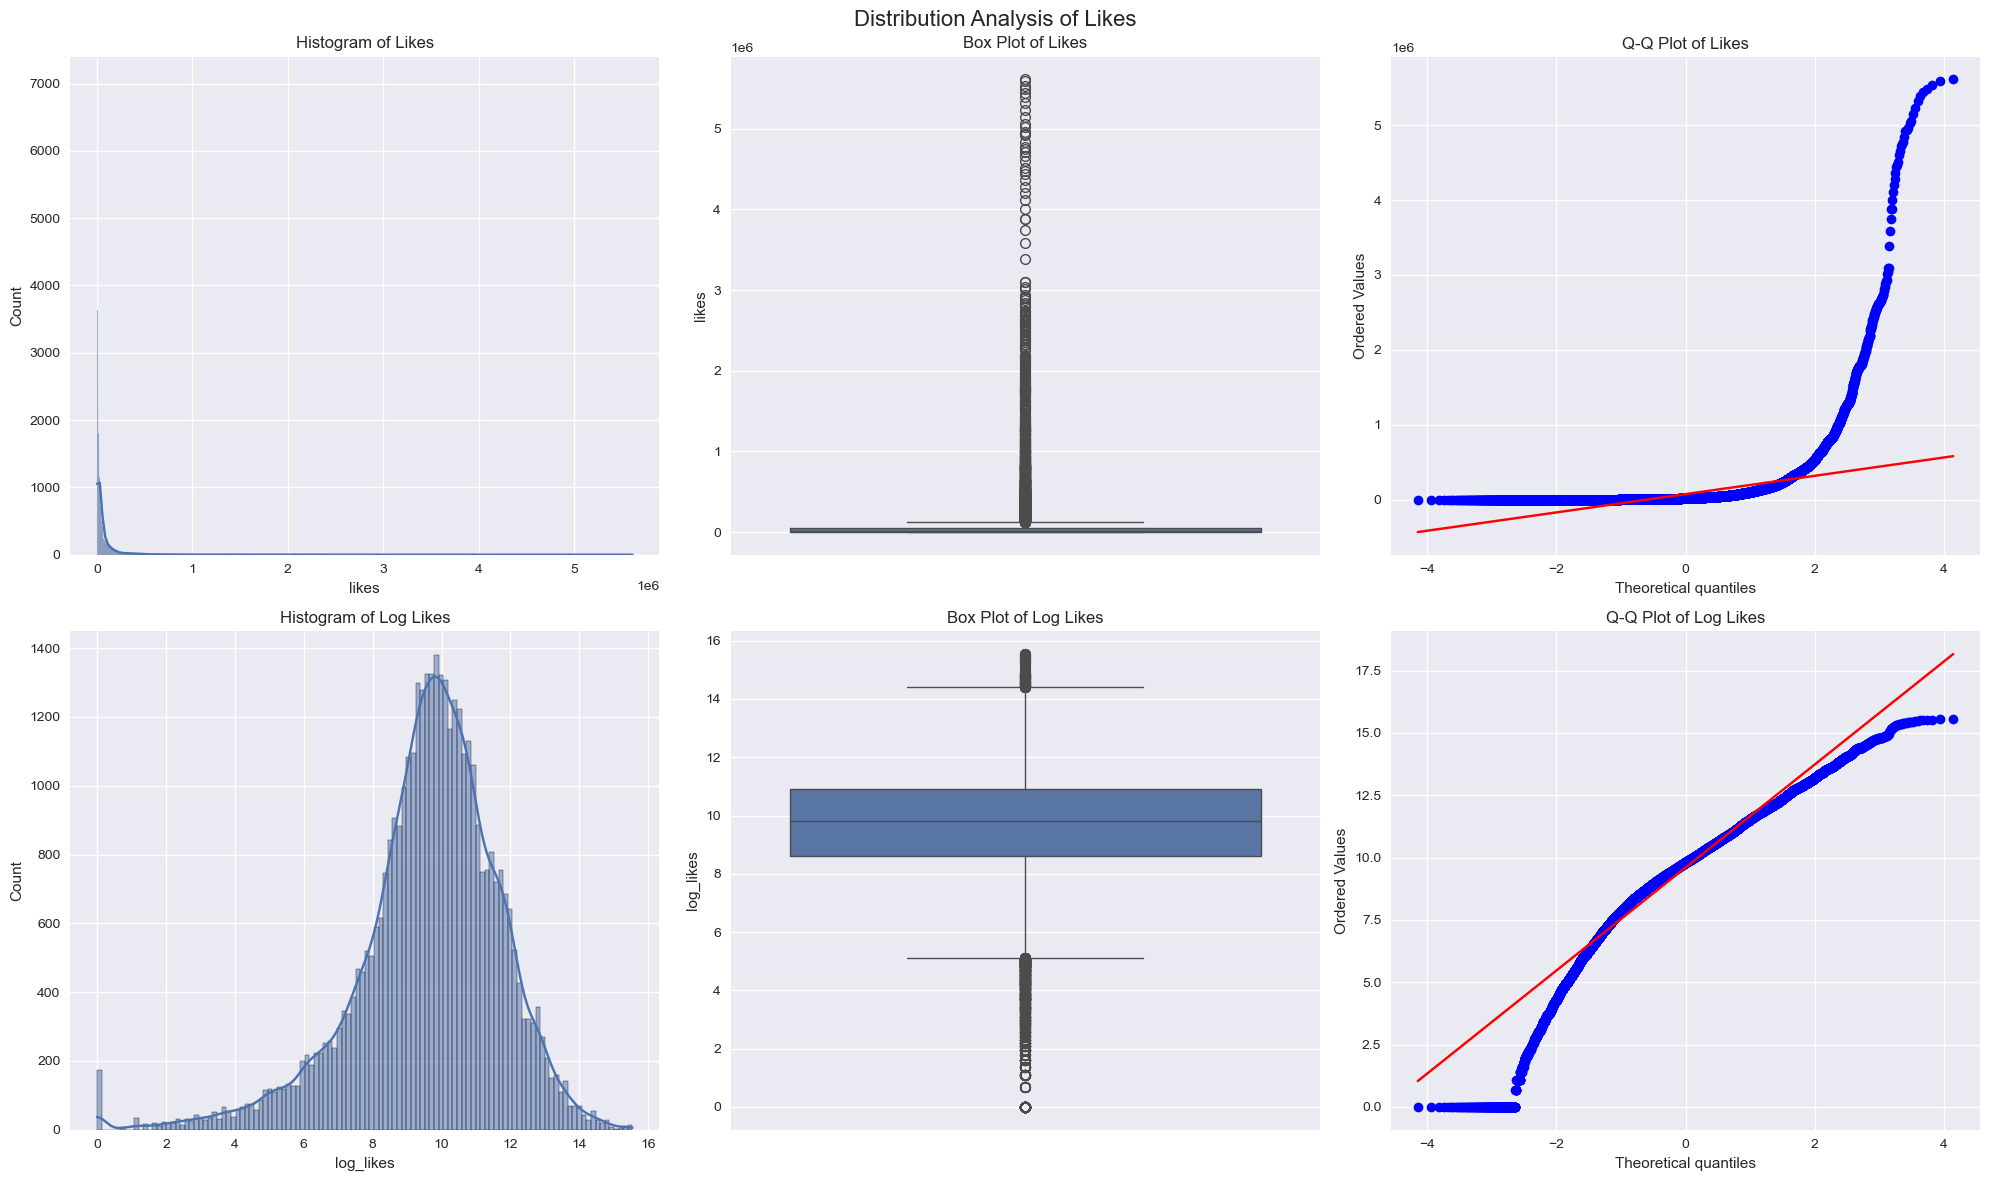

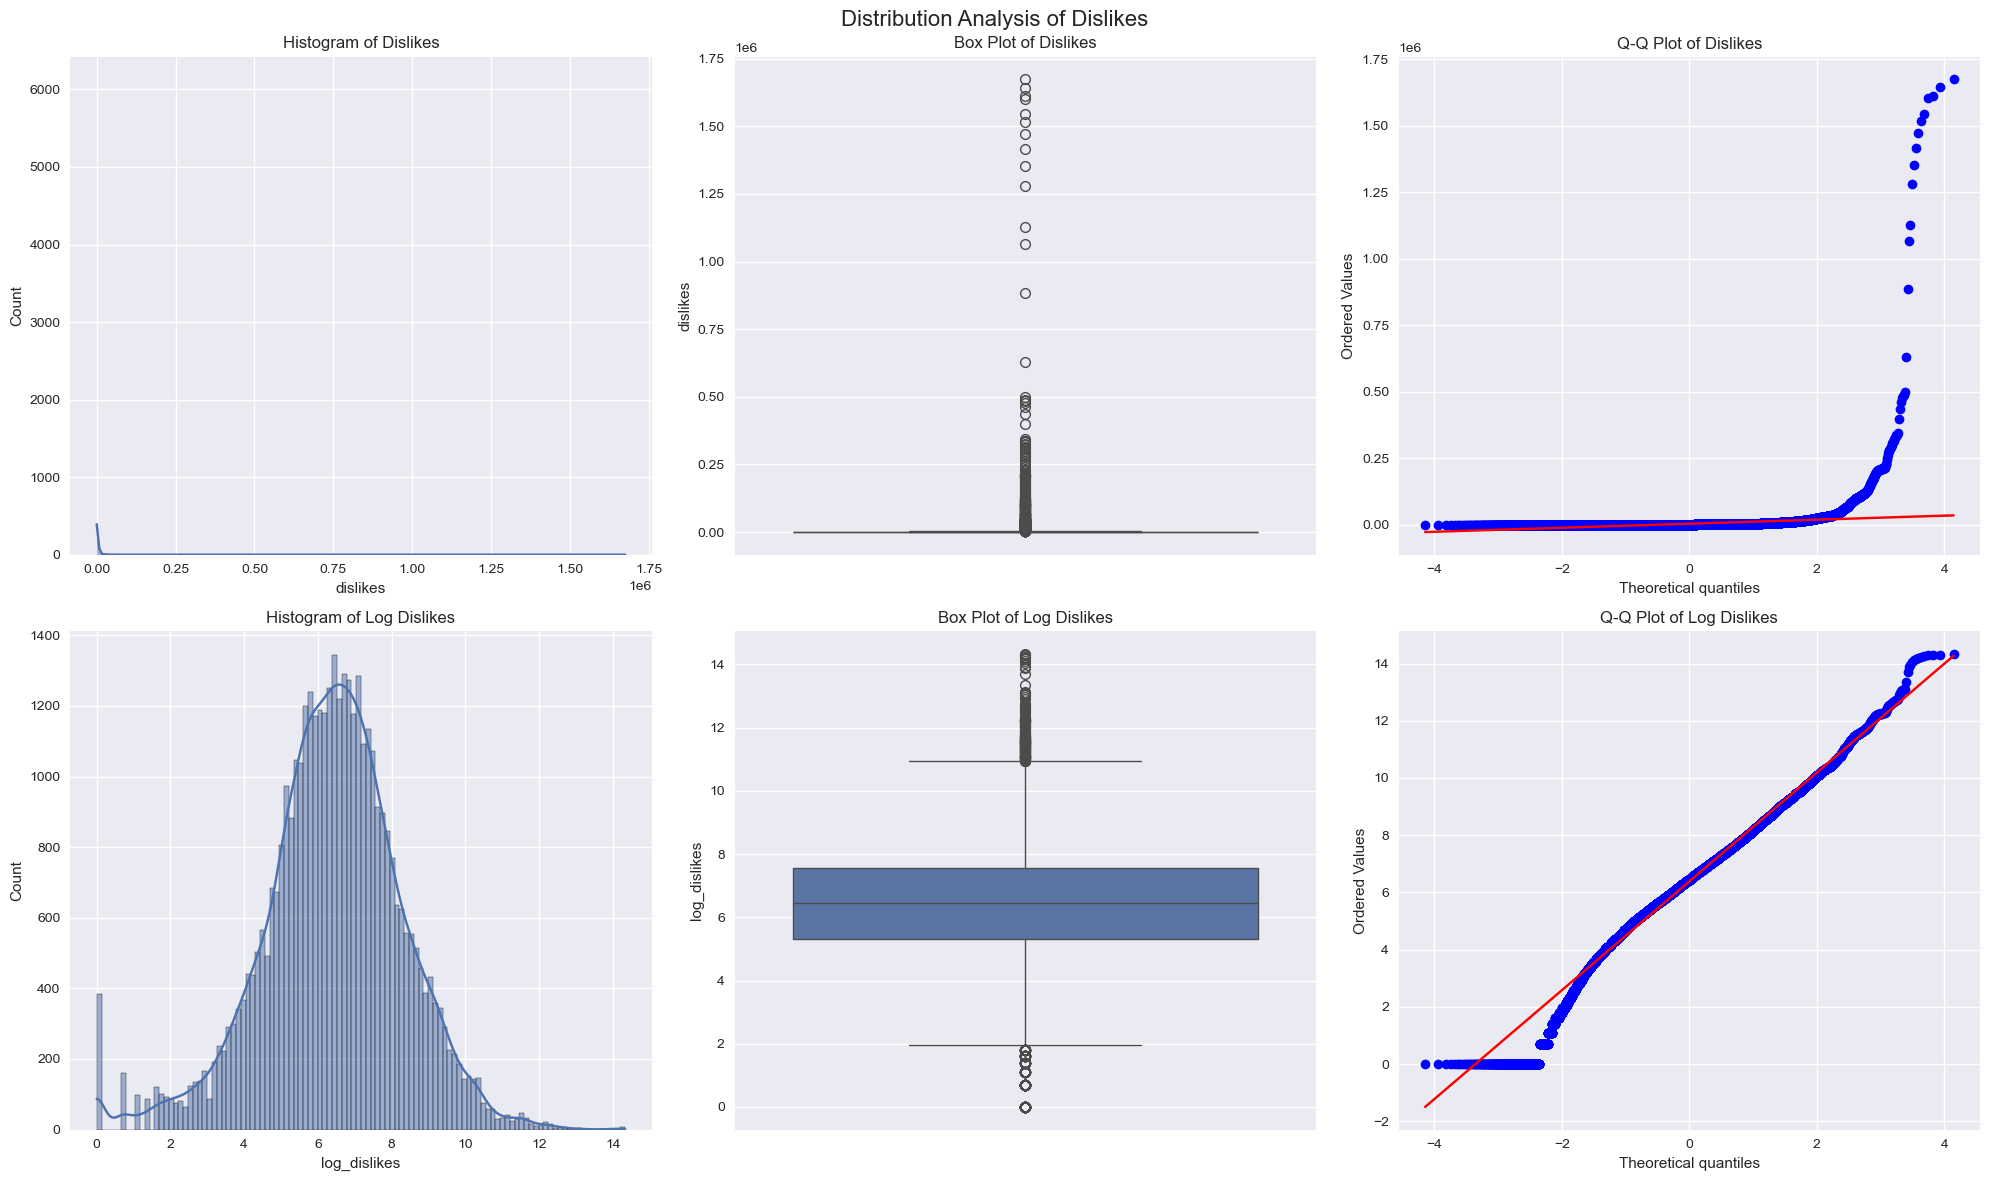

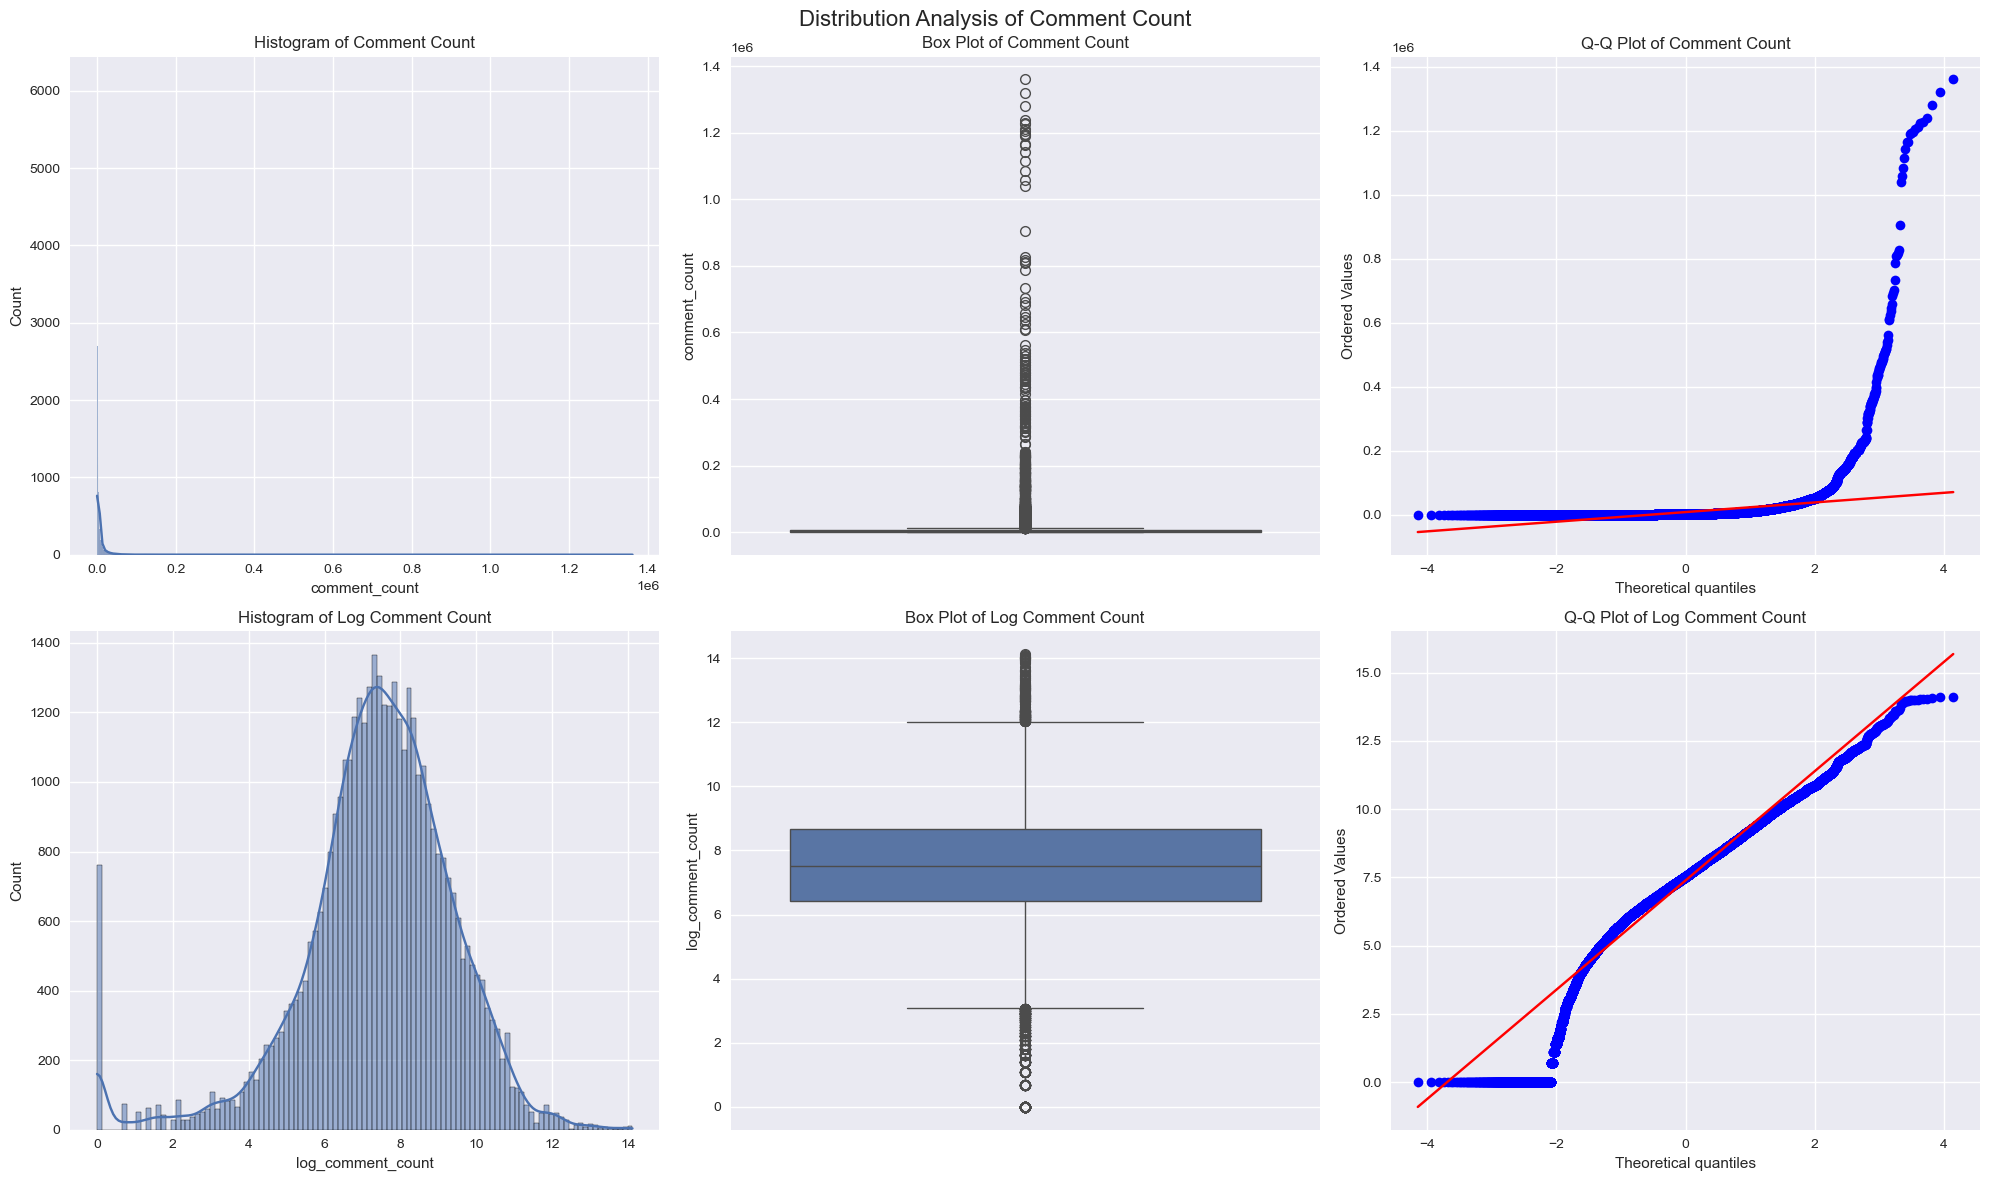

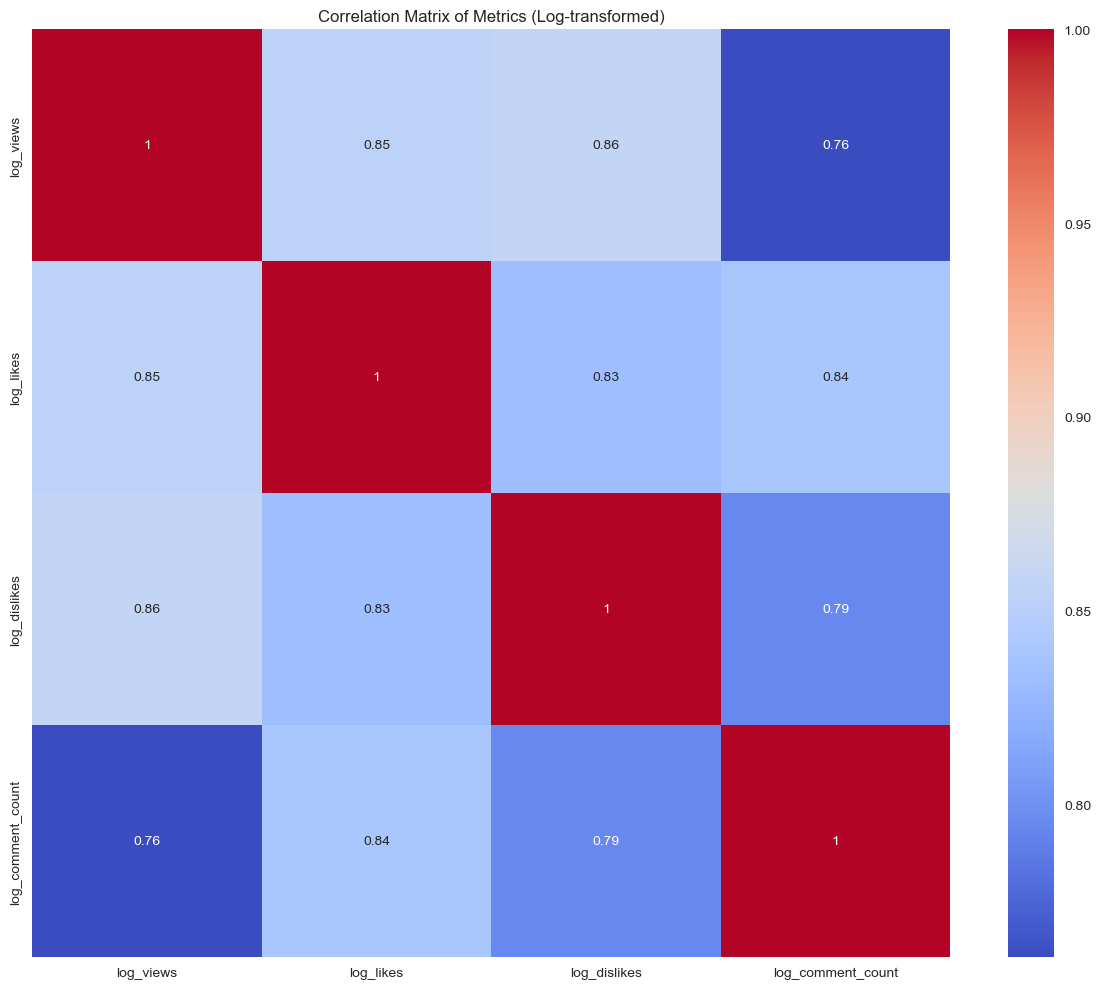


Z-score Analysis (Log-transformed)

Views Log-transformed Z-score Summary:
count    4.094900e+04
mean     6.218919e-16
std      1.000012e+00
min     -4.110063e+00
25%     -5.496825e-01
50%      5.531513e-02
75%      6.304709e-01
max      3.447173e+00
Name: log_views_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 5.32%


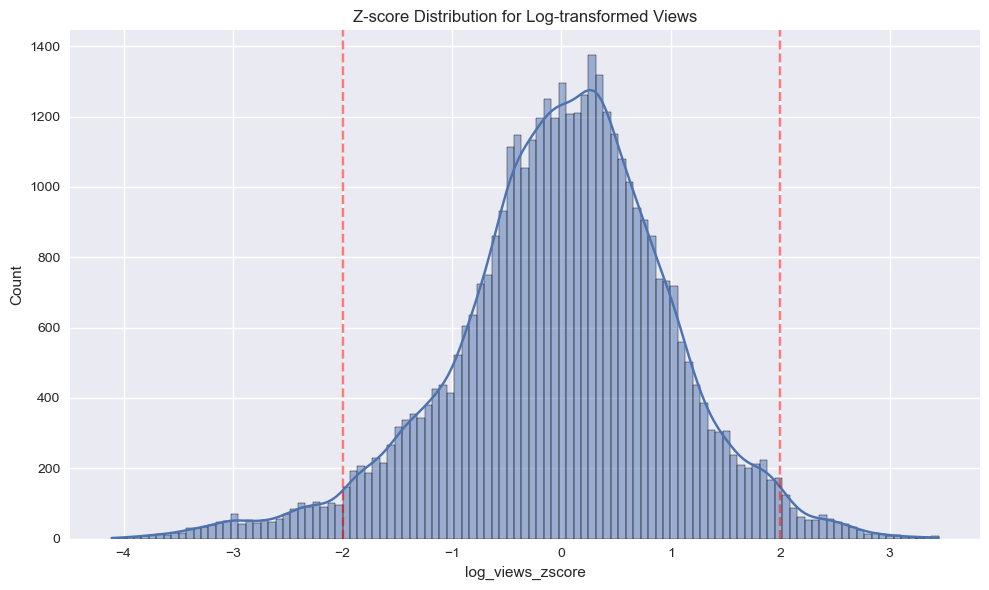


Likes Log-transformed Z-score Summary:
count    4.094900e+04
mean     2.221043e-17
std      1.000012e+00
min     -4.537220e+00
25%     -4.729496e-01
50%      9.634313e-02
75%      6.254518e-01
max      2.808222e+00
Name: log_likes_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 5.00%


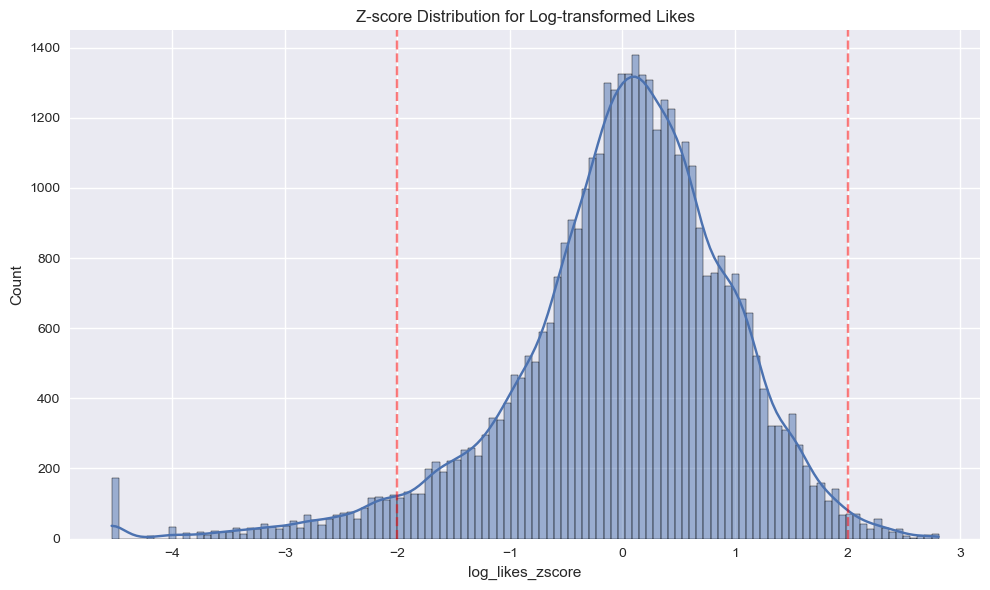


Dislikes Log-transformed Z-score Summary:
count    4.094900e+04
mean     1.776834e-16
std      1.000012e+00
min     -3.334593e+00
25%     -5.608829e-01
50%      3.199015e-02
75%      6.172178e-01
max      4.146762e+00
Name: log_dislikes_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 5.33%


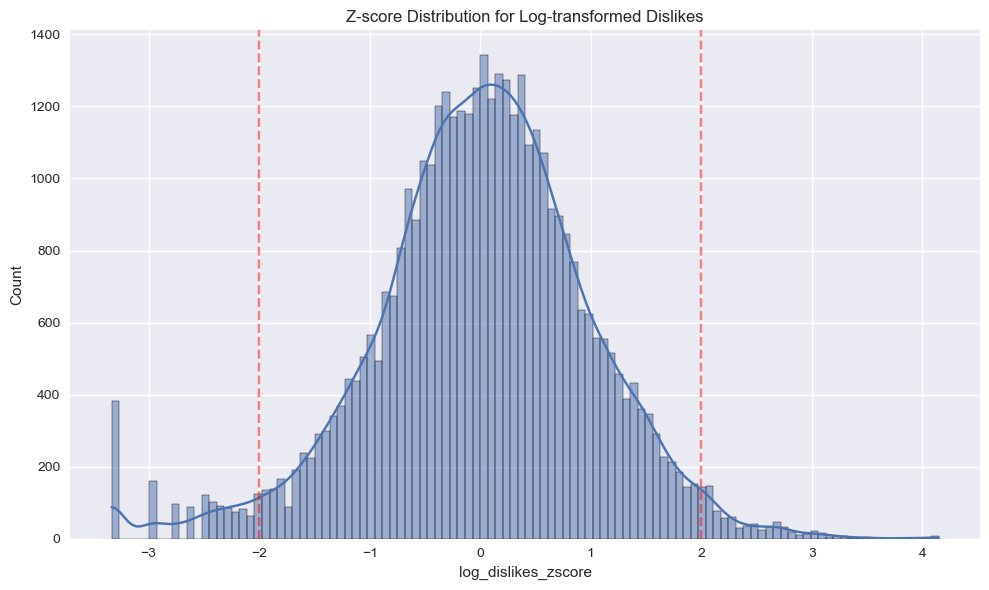


Comment_count Log-transformed Z-score Summary:
count    4.094900e+04
mean    -1.665782e-16
std      1.000012e+00
min     -3.591367e+00
25%     -4.696423e-01
50%      6.757441e-02
75%      6.175205e-01
max      3.274768e+00
Name: log_comment_count_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 4.97%


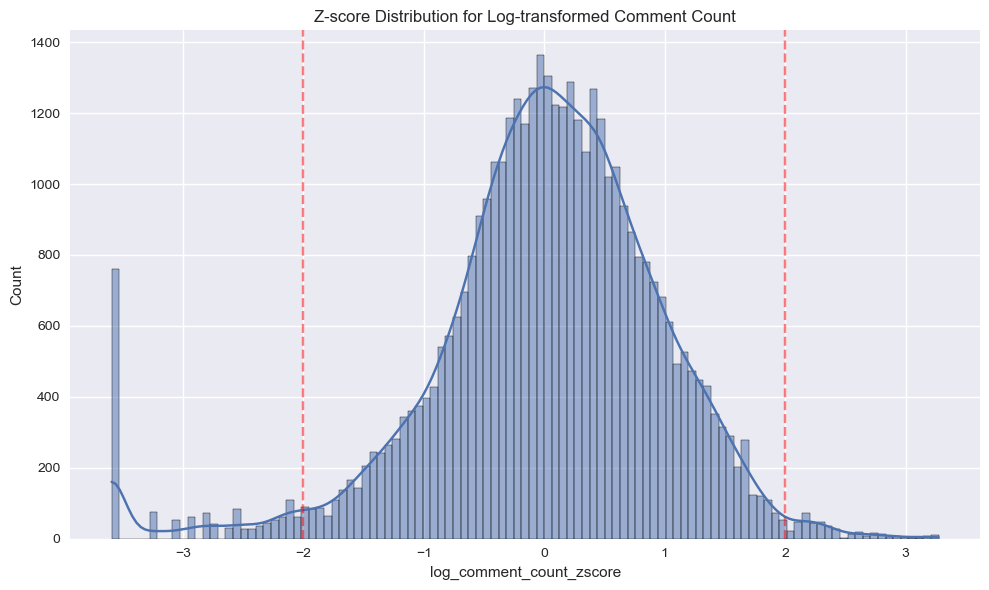


T-score Analysis by Category (Log-transformed)

Views Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 12.73
  T-statistic: -6.72
  p-value: 0.0000
Comedy:
  Log Mean: 13.53
  T-statistic: 8.55
  p-value: 0.0000
Education:
  Log Mean: 12.92
  T-statistic: -14.80
  p-value: 0.0000
Entertainment:
  Log Mean: 13.37
  T-statistic: 1.98
  p-value: 0.0476
Film & Animation:
  Log Mean: 13.72
  T-statistic: 10.11
  p-value: 0.0000
Gaming:
  Log Mean: 13.97
  T-statistic: 11.50
  p-value: 0.0000
Howto & Style:
  Log Mean: 13.03
  T-statistic: -14.72
  p-value: 0.0000
Music:
  Log Mean: 14.12
  T-statistic: 33.46
  p-value: 0.0000
News & Politics:
  Log Mean: 12.08
  T-statistic: -34.32
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 11.48
  T-statistic: -4.99
  p-value: 0.0000
People & Blogs:
  Log Mean: 13.20
  T-statistic: -5.04
  p-value: 0.0000
Pets & Animals:
  Log Mean: 12.86
  T-statistic: -10.36
  p-value: 0.0000
Science & Technology:
  Log Mean: 13.10
  T-stati

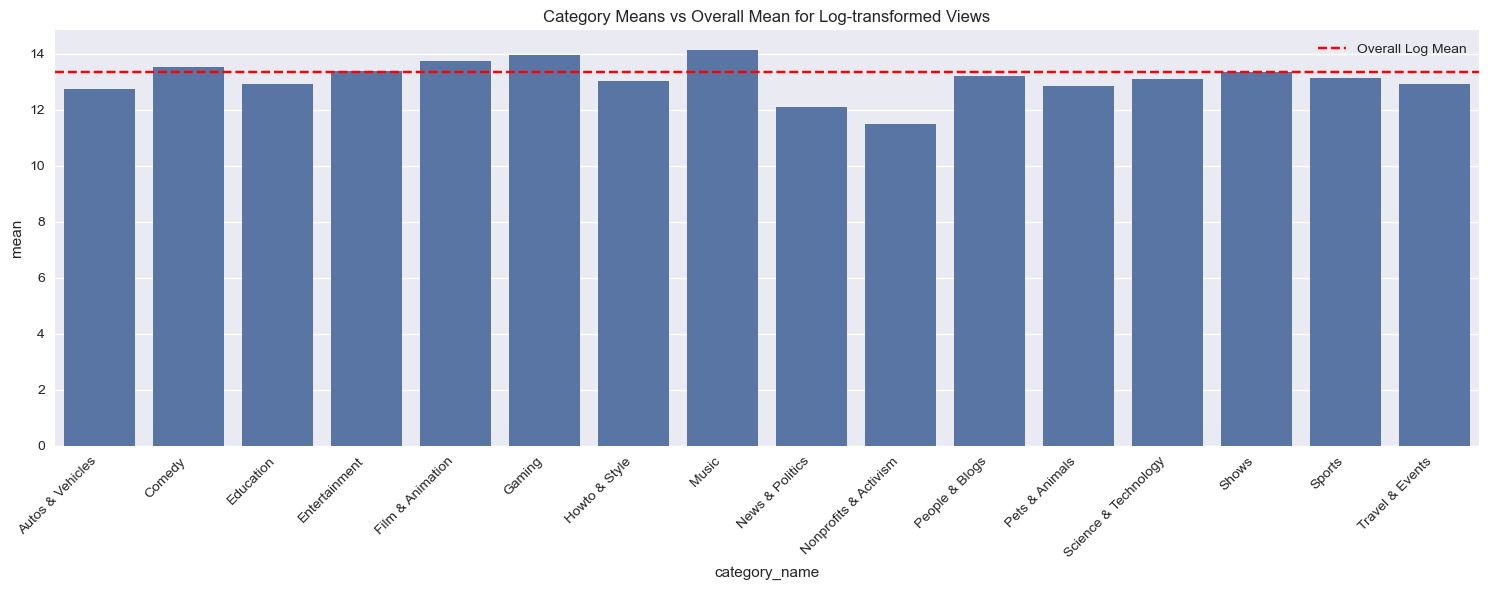


Likes Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 7.89
  T-statistic: -13.64
  p-value: 0.0000
Comedy:
  Log Mean: 10.15
  T-statistic: 20.27
  p-value: 0.0000
Education:
  Log Mean: 9.47
  T-statistic: -3.46
  p-value: 0.0006
Entertainment:
  Log Mean: 9.44
  T-statistic: -7.88
  p-value: 0.0000
Film & Animation:
  Log Mean: 9.71
  T-statistic: 2.39
  p-value: 0.0171
Gaming:
  Log Mean: 10.54
  T-statistic: 15.57
  p-value: 0.0000
Howto & Style:
  Log Mean: 9.78
  T-statistic: 7.82
  p-value: 0.0000
Music:
  Log Mean: 10.81
  T-statistic: 47.24
  p-value: 0.0000
News & Politics:
  Log Mean: 7.39
  T-statistic: -54.99
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 7.59
  T-statistic: -3.86
  p-value: 0.0003
People & Blogs:
  Log Mean: 9.61
  T-statistic: 0.40
  p-value: 0.6924
Pets & Animals:
  Log Mean: 9.28
  T-statistic: -6.79
  p-value: 0.0000
Science & Technology:
  Log Mean: 9.31
  T-statistic: -7.09
  p-value: 0.0000
Shows:
  Log Mean: 9.50
  T-sta

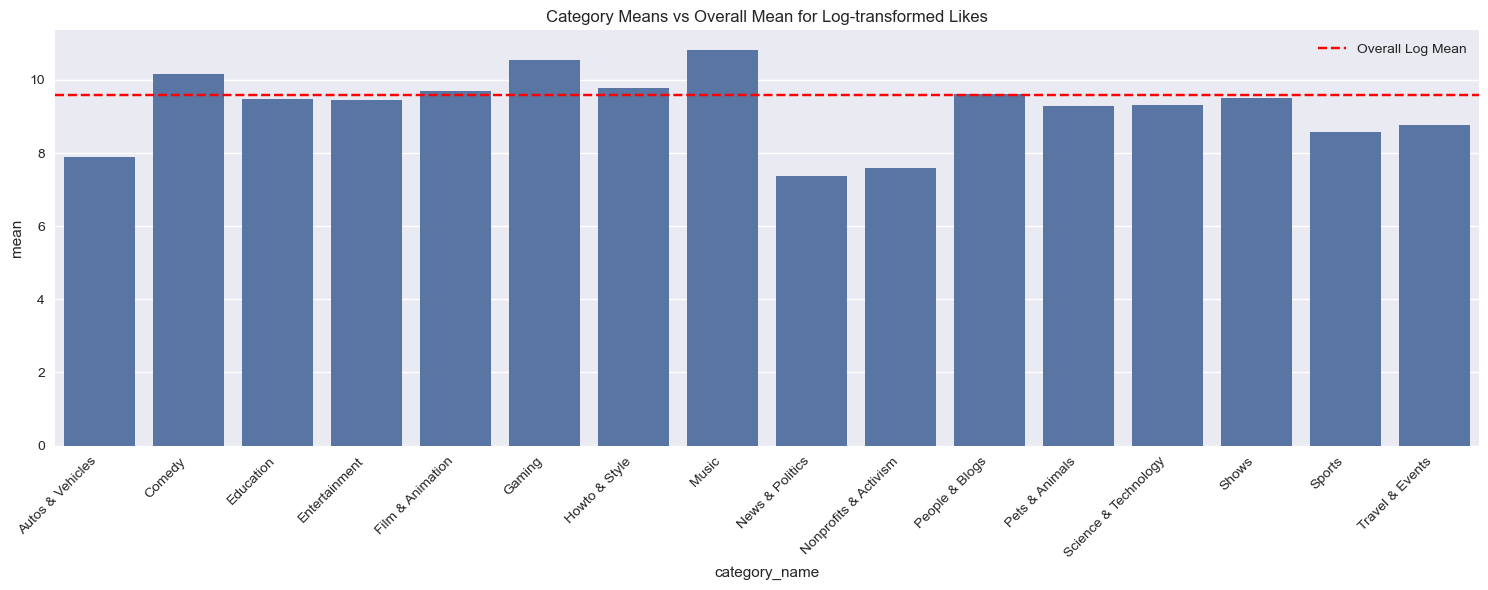


Dislikes Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 5.22
  T-statistic: -11.60
  p-value: 0.0000
Comedy:
  Log Mean: 6.71
  T-statistic: 12.41
  p-value: 0.0000
Education:
  Log Mean: 5.93
  T-statistic: -12.94
  p-value: 0.0000
Entertainment:
  Log Mean: 6.39
  T-statistic: 0.21
  p-value: 0.8356
Film & Animation:
  Log Mean: 6.57
  T-statistic: 4.39
  p-value: 0.0000
Gaming:
  Log Mean: 7.45
  T-statistic: 14.88
  p-value: 0.0000
Howto & Style:
  Log Mean: 6.18
  T-statistic: -8.82
  p-value: 0.0000
Music:
  Log Mean: 7.13
  T-statistic: 29.06
  p-value: 0.0000
News & Politics:
  Log Mean: 5.70
  T-statistic: -17.51
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 4.91
  T-statistic: -2.82
  p-value: 0.0067
People & Blogs:
  Log Mean: 6.24
  T-statistic: -4.11
  p-value: 0.0000
Pets & Animals:
  Log Mean: 5.49
  T-statistic: -17.82
  p-value: 0.0000
Science & Technology:
  Log Mean: 6.13
  T-statistic: -6.32
  p-value: 0.0000
Shows:
  Log Mean: 5.94
  T-

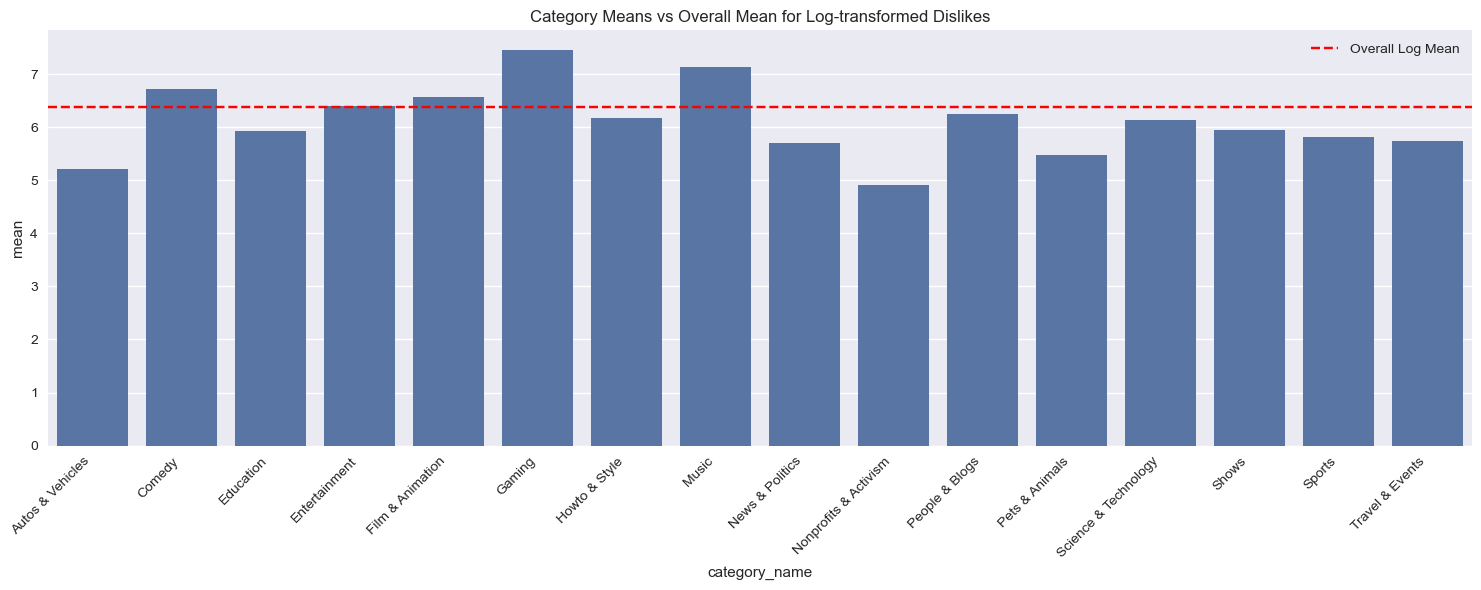


Comment_count Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 6.31
  T-statistic: -9.74
  p-value: 0.0000
Comedy:
  Log Mean: 7.77
  T-statistic: 13.58
  p-value: 0.0000
Education:
  Log Mean: 7.30
  T-statistic: -2.46
  p-value: 0.0139
Entertainment:
  Log Mean: 7.22
  T-statistic: -8.13
  p-value: 0.0000
Film & Animation:
  Log Mean: 7.51
  T-statistic: 2.71
  p-value: 0.0069
Gaming:
  Log Mean: 8.68
  T-statistic: 18.58
  p-value: 0.0000
Howto & Style:
  Log Mean: 7.47
  T-statistic: 3.41
  p-value: 0.0007
Music:
  Log Mean: 8.18
  T-statistic: 32.66
  p-value: 0.0000
News & Politics:
  Log Mean: 6.19
  T-statistic: -24.72
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 5.76
  T-statistic: -3.15
  p-value: 0.0027
People & Blogs:
  Log Mean: 7.32
  T-statistic: -1.85
  p-value: 0.0641
Pets & Animals:
  Log Mean: 7.00
  T-statistic: -7.26
  p-value: 0.0000
Science & Technology:
  Log Mean: 7.03
  T-statistic: -7.65
  p-value: 0.0000
Shows:
  Log Mean: 7.32
  

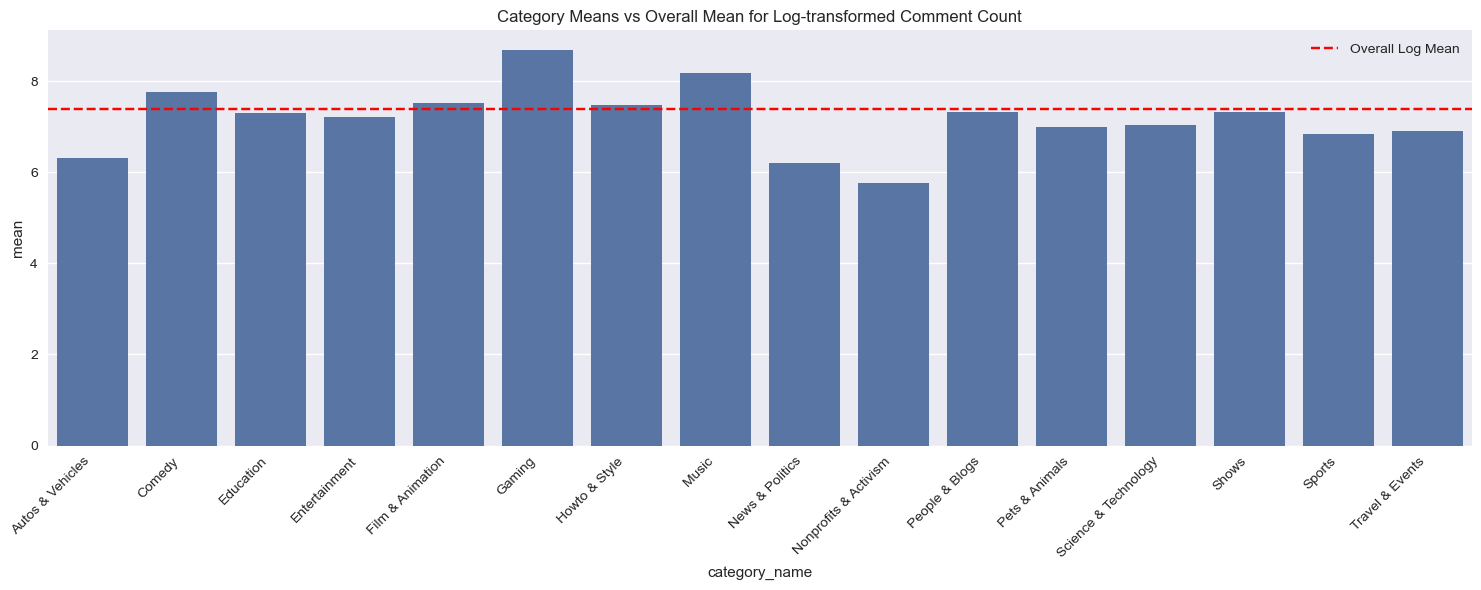

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from scipy.stats import shapiro, normaltest

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

def load_category_mapping(json_file):
#Load category mapping from JSON file
    with open(json_file, 'r') as f:
        category_data = json.load(f)
    formatted_categories = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
    return formatted_categories

def load_and_preprocess_data(csv_file, category_mapping):
#Load and preprocess the YouTube dataset
    df = pd.read_csv(csv_file)
    
    # Convert dates
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
    df['publish_time'] = pd.to_datetime(df['publish_time'])
    
    # Add category names column 
    df['category_name'] = df['category_id'].map(category_mapping)
    
    # Create log-transformed columns for numerical features
    numerical_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numerical_cols:
        df[f'log_{col}'] = np.log1p(df[col])
    
    # Add derived metrics
    df['likes_ratio'] = df['likes'] / (df['views'] + 1)
    df['dislikes_ratio'] = df['dislikes'] / (df['views'] + 1)
    df['comment_ratio'] = df['comment_count'] / (df['views'] + 1)
    
    return df

def plot_distribution_analysis(data, column, log_column, title):
#Create plots for both original and log-transformed data
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Distribution Analysis of {title}', fontsize=16)
    
    # Original data plots
    sns.histplot(data[column], kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Histogram of {title}')
    
    sns.boxplot(y=data[column], ax=axes[0,1])
    axes[0,1].set_title(f'Box Plot of {title}')
    
    stats.probplot(data[column], dist="norm", plot=axes[0,2])
    axes[0,2].set_title(f'Q-Q Plot of {title}')
    
    # Log-transformed plots
    sns.histplot(data[log_column], kde=True, ax=axes[1,0])
    axes[1,0].set_title(f'Histogram of Log {title}')
    
    sns.boxplot(y=data[log_column], ax=axes[1,1])
    axes[1,1].set_title(f'Box Plot of Log {title}')
    
    stats.probplot(data[log_column], dist="norm", plot=axes[1,2])
    axes[1,2].set_title(f'Q-Q Plot of Log {title}')
    
    plt.tight_layout()
    return fig

def analyze_metric(data, metric):
#Analysis of a metric, both original and log-transformed
    log_metric = f'log_{metric}'
    
    subsample = data.sample(n=1000, random_state=42) #taking a subsample of 1000 entries for the Shapiro-Wilk test

    # Original data statistics
    orig_stats = data[metric].describe()
    orig_shapiro = shapiro(subsample[metric])
    orig_normaltest = normaltest(data[metric])
    
    # Log-transformed statistics
    log_stats = data[log_metric].describe()
    log_shapiro = shapiro(subsample[log_metric])
    log_normaltest = normaltest(data[log_metric])
    
    return {
        'original': {
            'statistics': orig_stats,
            'shapiro_test': orig_shapiro,
            'normaltest': orig_normaltest
        },
        'log_transformed': {
            'statistics': log_stats,
            'shapiro_test': log_shapiro,
            'normaltest': log_normaltest
        }
    }

# Load dataset
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)
print(f"Loaded {len(df)} records")

print("\nDataset Overview:")
print(df.info())

# Main features we are considering
metrics = ['views', 'likes', 'dislikes', 'comment_count']

for metric in metrics:
    print(f"\n{'='*50}")
    print(f"Analysis for {metric.upper()}")
    print(f"{'='*50}")
    
    # Create visualization
    fig = plot_distribution_analysis(df, metric, f'log_{metric}', metric.replace('_', ' ').title())
    
    # Perform analysis
    analysis_results = analyze_metric(df, metric)
    
    # Print results
    print("\nOriginal Data Statistics:")
    print(analysis_results['original']['statistics'])
    print(f"Shapiro-Wilk test: statistic={analysis_results['original']['shapiro_test'][0]:.4f}, p-value={analysis_results['original']['shapiro_test'][1]:.4e}")
    
    print("\nLog-Transformed Data Statistics:")
    print(analysis_results['log_transformed']['statistics'])
    print(f"Shapiro-Wilk test: statistic={analysis_results['log_transformed']['shapiro_test'][0]:.4f}, p-value={analysis_results['log_transformed']['shapiro_test'][1]:.4e}")

# 1. Correlation Analysis
print("\nCorrelation Analysis")
print("="*50)
correlation_matrix = df[[f'log_{m}' for m in metrics]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Metrics (Log-transformed)')
plt.tight_layout()
plt.show()

# Modified Z-score Analysis using log-transformed metrics
print("\nZ-score Analysis (Log-transformed)")
print("="*50)

for metric in metrics:
    log_metric = f'log_{metric}'
    
    # Calculate Z-scores using log-transformed data
    df[f'{log_metric}_zscore'] = stats.zscore(df[log_metric])
    
    # Print Z-score summary statistics
    print(f"\n{metric.capitalize()} Log-transformed Z-score Summary:")
    print(df[f'{log_metric}_zscore'].describe())
    
    # Calculate and print percentage of videos beyond 2 standard deviations
    outliers = np.abs(df[f'{log_metric}_zscore']) > 2
    outlier_percentage = (outliers.sum() / len(df)) * 100
    print(f"Percentage of videos beyond 2 standard deviations: {outlier_percentage:.2f}%")
    
    # Create Z-score distribution plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[f'{log_metric}_zscore'], kde=True)
    plt.title(f'Z-score Distribution for Log-transformed {metric.replace("_", " ").title()}')
    plt.axvline(x=2, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=-2, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Modified T-score Analysis using log-transformed metrics
print("\nT-score Analysis by Category (Log-transformed)")
print("="*50)

for metric in metrics:
    log_metric = f'log_{metric}'
    print(f"\n{metric.capitalize()} Log-transformed T-scores by category:")
    overall_log_mean = df[log_metric].mean()
    
    # Calculate T-scores for each category using log-transformed data
    category_stats = df.groupby('category_name').agg({
        log_metric: ['mean', 'count', 'std']
    }).reset_index()
    
    category_stats.columns = ['category_name', 'mean', 'count', 'std']
    
    for _, row in category_stats.iterrows():
        category = row['category_name']
        category_log_data = df[df['category_name'] == category][log_metric]
        
        # Perform one-sample t-test on log-transformed data
        t_stat, p_value = stats.ttest_1samp(category_log_data, overall_log_mean)
        
        print(f"{category}:")
        print(f"  Log Mean: {row['mean']:.2f}")
        print(f"  T-score: {t_stat:.2f}")
        print(f"  p-value: {p_value:.4f}")
    
    # Visualize category means compared to overall mean
    plt.figure(figsize=(15, 6))
    sns.barplot(x='category_name', y='mean', data=category_stats)
    plt.axhline(y=overall_log_mean, color='r', linestyle='--', label='Overall Log Mean')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Category Means vs Overall Mean for Log-transformed {metric.replace("_", " ").title()}')
    plt.legend()
    plt.tight_layout()
    plt.show()